In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this function is made to load the batchwise embeddings and parquets for training the model, because the files are stored batch wise
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader

class BatchwiseFinBERTDataset(Dataset):
    def __init__(self, parquet_dir, pt_dir, batch_size_map):
        self.parquet_dir = parquet_dir
        self.pt_dir = pt_dir
        self.batch_size_map = batch_size_map
        self.batch_indices = list(batch_size_map.keys())
        self.total_samples = sum(batch_size_map.values())

        # Map each global sample index to batch_start index
        self.index_to_batch_start = []
        for batch_start, size in batch_size_map.items():
            self.index_to_batch_start.extend([batch_start] * size)

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        batch_start = self.index_to_batch_start[idx]
        local_idx = idx - sum(self.batch_size_map[k] for k in self.batch_indices if k < batch_start)

        # Load tensors from disk
        input_ids = torch.load(os.path.join(self.pt_dir, f"input_ids_batch_{batch_start}.pt"), map_location="cpu")[local_idx]
        attention_mask = torch.load(os.path.join(self.pt_dir, f"attention_mask_batch_{batch_start}.pt"), map_location="cpu")[local_idx]

        # Load associated data from Parquet
        parquet_path = os.path.join(self.parquet_dir, f"risk_matrix_{batch_start}.parquet")
        df = pd.read_parquet(parquet_path)

        narrative_values = df.iloc[local_idx][df.columns.str.startswith("narrative_")].astype(float).values.astype("float32")
        narrative_tensor = torch.tensor(narrative_values, dtype=torch.float32)

        label = torch.tensor(df.iloc[local_idx]["risk_score"], dtype=torch.long)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "narratives": narrative_tensor,
            "labels": label
        }

In [ ]:
# making a batch reference map for determining the batch of each row because some were stored in batch size 4 and some in 1
parquet_path = "/content/drive/MyDrive/DeepLearningProject/Parquet_Batches"
pt_path = "/content/drive/MyDrive/DeepLearningProject/Fibert_Batches"

batch_size_map = {}
for i in range(0, 47 * 4, 4):
    batch_size_map[i] = 4
for i in range(192, 478):
    batch_size_map[i] = 1


dataset = BatchwiseFinBERTDataset(parquet_path, pt_path, batch_size_map)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

val_size = int(0.2 * len(dataset))  # 20% for validation
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [ ]:
# defining the architecture of the neural network
import torch.nn as nn
from transformers import AutoModel

class RiskClassifier(nn.Module):
    def __init__(self, narrative_size=5, num_classes=5):
        super(RiskClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("yiyanghkust/finbert-pretrain")
        self.dropout = nn.Dropout(0.3)

        # BERT's pooled output is 768-d, narrative vector is narrative_size
        self.classifier = nn.Sequential(
            nn.Linear(768 + narrative_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, narratives):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.pooler_output  # shape: (batch_size, 768)
        combined = torch.cat((cls_output, narratives), dim=1)
        logits = self.classifier(self.dropout(combined))
        return logits

In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparams = {
    "learning_rate": 2e-5,
    "epochs": 1,
    "batch_size": 1  # already used in dataloader
}

model = RiskClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
all_preds = []
all_labels = []
all_probs = []

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            narratives = batch["narratives"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, narratives)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                narratives = batch["narratives"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask, narratives)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                probs = torch.softmax(outputs, dim=1)  # Get probabilities
                _, predicted = probs.max(1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())  # Store probability vectors

                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Acc: {val_acc:.4f}")

In [ ]:
train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5)

Epoch 1 | Train Loss: 0.0630 | Train Acc: 0.9868
Validation Loss: 1.1898 | Validation Acc: 0.7234
Epoch 2 | Train Loss: 0.0291 | Train Acc: 0.9974
Validation Loss: 1.2812 | Validation Acc: 0.7234
Epoch 3 | Train Loss: 0.0335 | Train Acc: 0.9921
Validation Loss: 1.4015 | Validation Acc: 0.7234
Epoch 4 | Train Loss: 0.0259 | Train Acc: 0.9947
Validation Loss: 1.4069 | Validation Acc: 0.7234
Epoch 5 | Train Loss: 0.0275 | Train Acc: 0.9947
Validation Loss: 1.4612 | Validation Acc: 0.7340


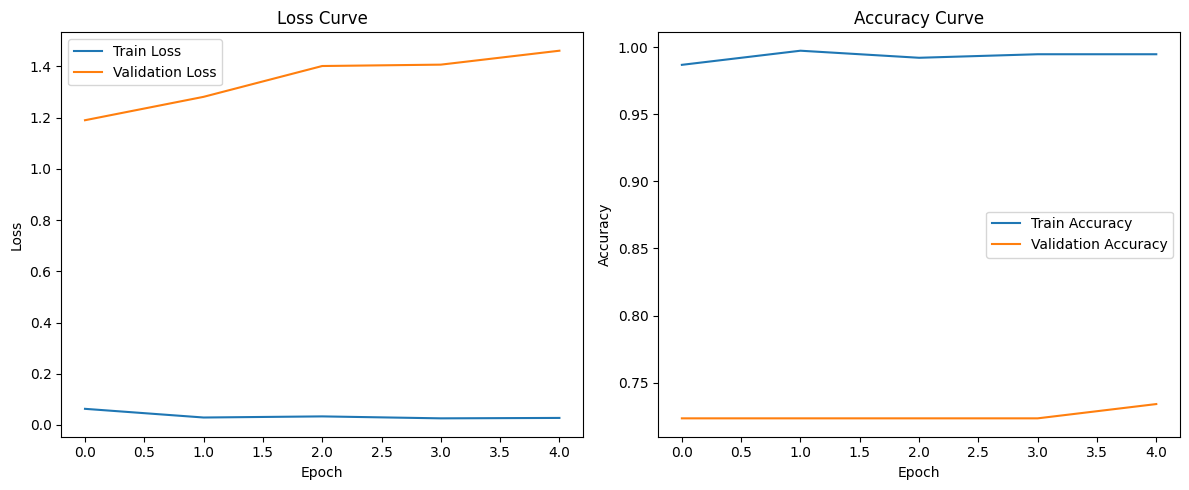

In [ ]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

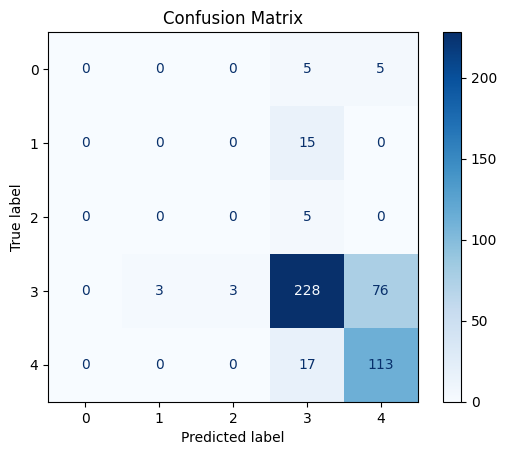

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Weighted average: accounts for class imbalance
weighted_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
weighted_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("🔍 Weighted Precision:", round(weighted_precision, 4))
print("🔍 Weighted Recall:", round(weighted_recall, 4))
print("🔍 Weighted F1 Score:", round(weighted_f1, 4))


🔍 Weighted Precision: 0.7181
🔍 Weighted Recall: 0.7255
🔍 Weighted F1 Score: 0.7115


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = np.array(all_labels)
y_prob = np.array(all_probs)

# One-vs-Rest AUC for multi-class (macro average)
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
print(f"ROC-AUC Score (macro): {roc_auc:.4f}")

🔵 ROC-AUC Score (macro): 0.6994


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Convert to NumPy arrays if not already
y_true = np.array(all_labels)
y_score = np.array(all_probs)

# Binarize the labels for multi-class ROC
n_classes = y_score.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

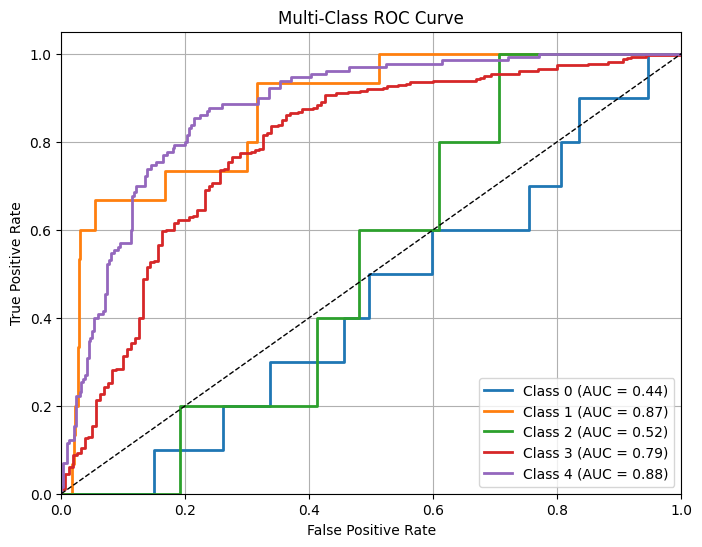

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Convert to arrays
y_true = np.array(all_labels)               # shape: (num_samples,)
y_score = np.array(all_probs)               # shape: (num_samples, num_classes)
n_classes = y_score.shape[1]

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute macro-averaged ROC AUC
macro_auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')

print(f"📊 Macro-Averaged ROC AUC: {macro_auc:.4f}")


📊 Macro-Averaged ROC AUC: 0.6994


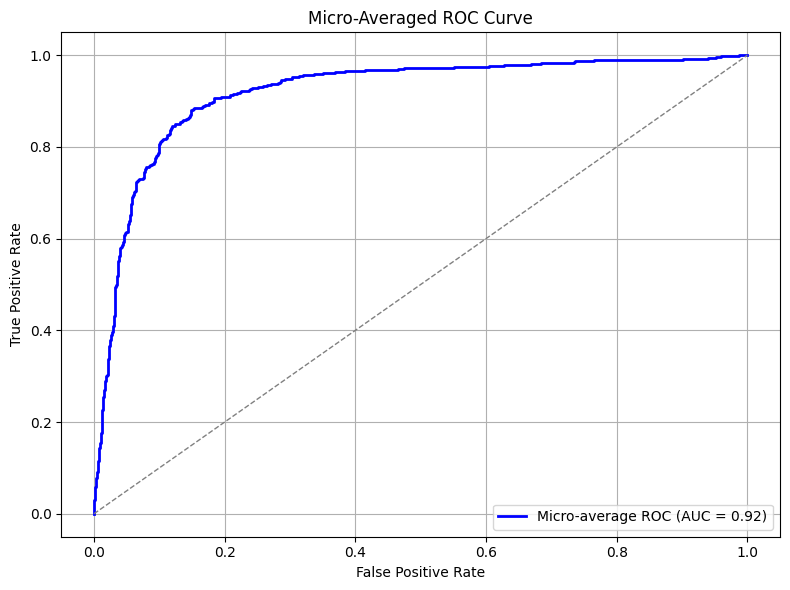

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have:
# - all_labels: true labels (list of ints)
# - all_probs: predicted probabilities (list of lists or np.array), shape (n_samples, n_classes)

y_true = np.array(all_labels)
y_score = np.array(all_probs)
n_classes = y_score.shape[1]

# Binarize labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color="blue", lw=2,
         label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Averaged ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()